In [306]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set3 as invariant_set3
import cp_reach.satellite.plotting as plotting
import cp_reach.satellite.HCW as HCW
import cp_reach.satellite.TH_LTV as TH_LTV
import cp_reach.physics.rigid_body as rigid_body
import sympy as sp

import cp_reach.satellite.mission2 as sat_sim
import cyecca.lie as lie
import casadi as ca

In [307]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
%autoreload 2

# Define Mission Parameters

In [309]:
thrust = 10
ang_vel_dist_deg = 0.01 # in degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
gravity_err = 0.00 # m/s^2
accel_dist = 1 #m/s^2
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)
acc = [thrust, 0, 0]

In [310]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['a_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)

        
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['a_d_amp'] = accel_dist
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

In [321]:
sat_coast = sat_sim.SatSimCoast()
res = sat_burn.simulate(t_vect, integrator='rk')

# 10 Second Burn - Monte Carlo and Reference

In [311]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, 20, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

## LMI for log-linearized system

In [312]:
xi_points, eta_points, bounds_log, sol = invariant_set3.solve(ang_vel_dist_rad, accel_dist, acc, control_gains, num_points=1000)

In [313]:
bounds_log

array([[-1.57324447,  1.57324447],
       [-1.57370718,  1.57370718],
       [-1.57370718,  1.57370718],
       [-1.47513664,  1.47513664],
       [-1.47508128,  1.47508128],
       [-1.47508129,  1.47508129],
       [-0.0054742 ,  0.0054742 ],
       [-0.00547426,  0.00547426],
       [-0.00682373,  0.00682373]])

In [314]:
# i = 4
# j = 5
# plt.scatter(eta_points[i,:],eta_points[j,:])
# plt.scatter(xi_points[i,:],xi_points[j,:])
# plt.xlabel('deltav y')
# plt.ylabel('deltav z')

## LMI for HCW system

In [315]:
mu = 3.986e14      # [m^3/s^2]
r0 = 42164e3          # [m]
ref_n = np.sqrt(mu / r0**3)

hcw_sol = HCW.solve_hcw_invariant_set(ref_n, accel_dist, Kp=Kp, Kd=Kd)
hcw_sol
mu1 = hcw_sol['mu']  # acceleration disturbance multiplier
P_hcw = hcw_sol['P']
val_hcw = mu1 * accel_dist**2 
P_hcw_scaled = P_hcw / val_hcw
hcw_points = HCW.sample_ellipsoid_boundary_6(P_hcw_scaled, n=600)

hcw_min = np.min(hcw_points, axis=1)
hcw_max = np.max(hcw_points, axis=1)
bounds_hcw = np.column_stack([hcw_min, hcw_max])

In [316]:
bounds_hcw

array([[-1.56810452,  1.56810452],
       [-1.56810452,  1.56810452],
       [-1.56810452,  1.56810452],
       [-1.47316118,  1.47316118],
       [-1.47316121,  1.47316121],
       [-1.47316125,  1.47316125]])

## LMI for TH system

In [318]:
mu = 3.986e14      # [m^3/s^2]
ref_orbit = data_burn_ref['xf'][1:7,:].T
bounds= TH_LTV.th_param_bounds_from_traj(ref_orbit, mu)
th_sol = TH_LTV.solve_YA_TH_LTV_invariant_set_from_bounds(bounds, accel_dist,Kp=Kp, Kd=Kd)
print(th_sol)
mu1 = th_sol['mu']  # acceleration disturbance multiplier
P_th = th_sol['P']
val_th = mu1 * accel_dist**2
print(mu1)
P_th_scaled = P_th / val_th
th_points = TH_LTV.sample_ellipsoid_boundary_6(P_th_scaled, n=600)

th_min = np.min(th_points, axis=1)
th_max = np.max(th_points, axis=1)
bounds_th = np.column_stack([th_min, th_max])

[7.28109288e-05 7.28133004e-05 7.28156721e-05 ... 7.75471900e-05
 7.75495617e-05 7.75519333e-05] [-0.00000000e+00  2.32268867e-17  4.59523030e-17 ... -1.04131227e-12
 -1.04242392e-12 -1.04353620e-12] 0.008157291257623406
{'P': array([[ 1.21149280e+00, -4.80637520e-18,  1.10530336e-12,
         2.82836032e-01, -6.94772389e-17, -7.18989674e-05],
       [-4.80637520e-18,  1.21149282e+00, -4.36472811e-16,
         1.32266789e-16,  2.82836032e-01,  1.44127018e-16],
       [ 1.10530336e-12, -4.36472811e-16,  1.21149279e+00,
         7.18989666e-05, -4.58588056e-17,  2.82836032e-01],
       [ 2.82836032e-01,  1.32266789e-16,  7.18989666e-05,
         1.37824426e+00,  2.00054136e-16,  1.16183125e-12],
       [-6.94772389e-17,  2.82836032e-01, -4.58588056e-17,
         2.00054136e-16,  1.37824426e+00, -7.49366423e-16],
       [-7.18989674e-05,  1.44127018e-16,  2.82836032e-01,
         1.16183125e-12, -7.49366423e-16,  1.37824427e+00]]), 'mu': 2.847882356855607, 'cost': 2.847882356855607, 'alph

In [319]:
bounds_th

array([[-1.56813285,  1.56813285],
       [-1.56813284,  1.56813284],
       [-1.56813286,  1.56813286],
       [-1.47319023,  1.47319023],
       [-1.47319023,  1.47319023],
       [-1.47319023,  1.47319023]])

## Plot

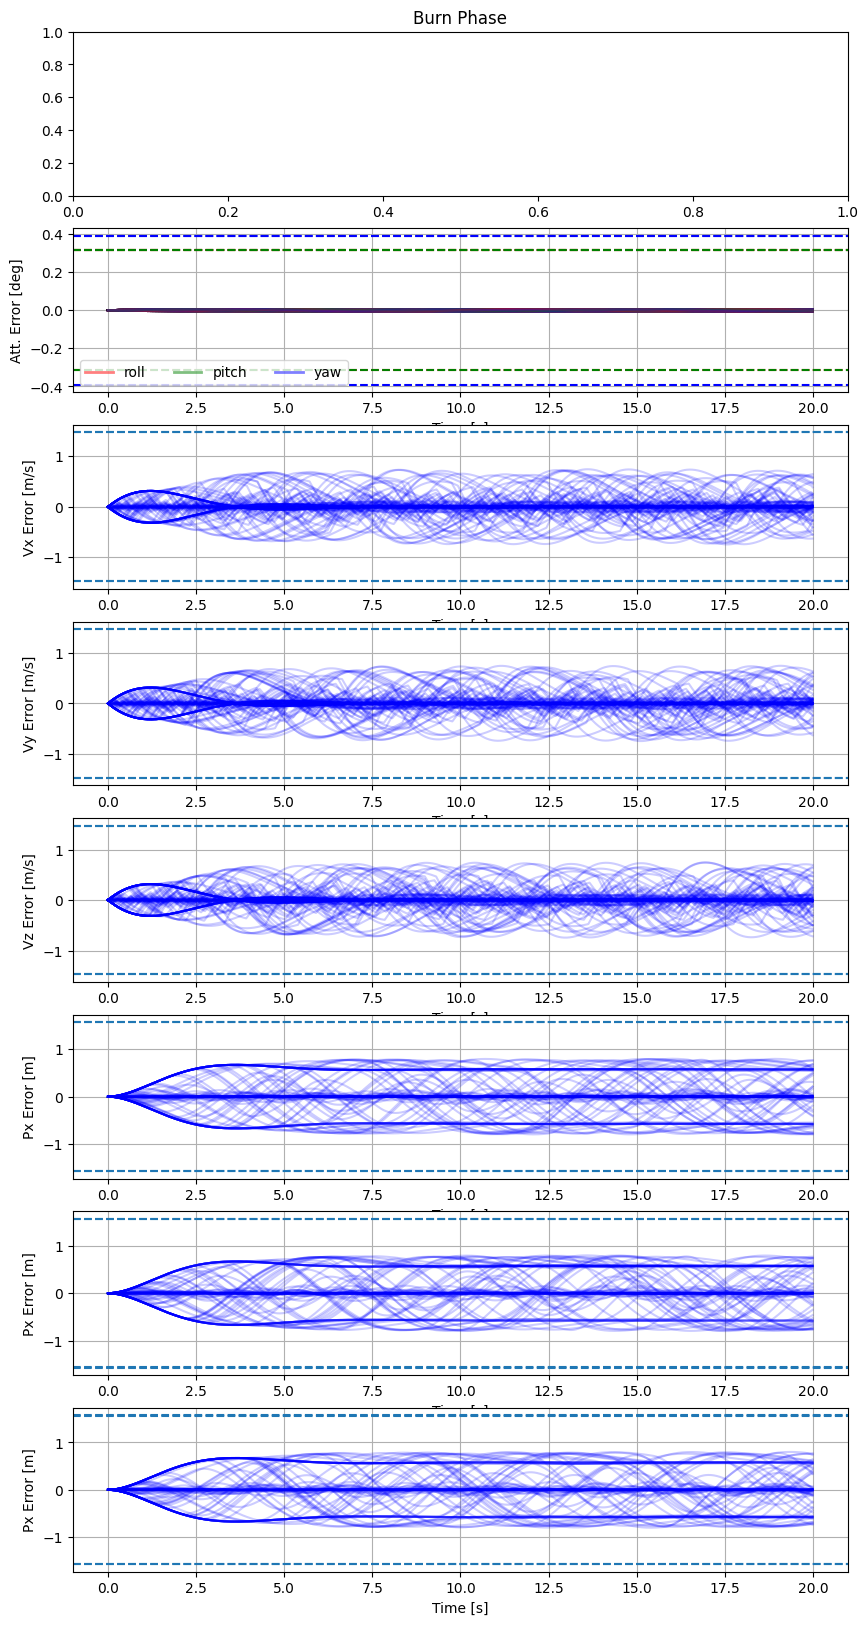

In [320]:
def burn_plotting(data_burn, bounds):
    fig, axes = plt.subplots(8, 1, figsize=(10, 20))
    axes[0].set_title('Burn Phase')
    colors = ['r','g','b']

    # Attitude
    plotting.plot_burn_attitude(axes[1], data_burn)
    for i in range(3):
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 0]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])

    # Vx
    plotting.plot_burn_delta_vx_error(axes[2], data_burn)
    axes[2].axhline(y=bounds_log[3, 0], linestyle='--')
    axes[2].axhline(y=bounds_log[3, 1], linestyle='--')

    # axes[2].axhline(y=bounds_hcw[3, 0], linestyle='--')
    # axes[2].axhline(y=bounds_hcw[3, 1], linestyle='--')

    axes[2].axhline(y=bounds_th[3, 0], linestyle='--')
    axes[2].axhline(y=bounds_th[3, 1], linestyle='--')
    

    #V y
    plotting.plot_burn_delta_vy_error(axes[3], data_burn)
    axes[3].axhline(y=bounds_log[4, 0], linestyle='--')
    axes[3].axhline(y=bounds_log[4, 1], linestyle='--')

    # axes[3].axhline(y=bounds_hcw[4, 0], linestyle='--')
    # axes[3].axhline(y=bounds_hcw[4, 1], linestyle='--')

    axes[3].axhline(y=bounds_th[4, 0], linestyle='--')
    axes[3].axhline(y=bounds_th[4, 1], linestyle='--')

    # Vz
    plotting.plot_burn_delta_vz_error(axes[4], data_burn)
    axes[4].axhline(y=bounds_log[5, 0], linestyle='--')
    axes[4].axhline(y=bounds_log[5, 1], linestyle='--')

    # axes[4].axhline(y=bounds_hcw[5, 0], linestyle='--')
    # axes[4].axhline(y=bounds_hcw[5, 1], linestyle='--')

    axes[4].axhline(y=bounds_th[5, 0], linestyle='--')
    axes[4].axhline(y=bounds_th[5, 1], linestyle='--')

    # Px
    plotting.plot_burn_x_error(axes[5], data_burn)
    axes[5].axhline(y=bounds_log[0, 0], linestyle='--')
    axes[5].axhline(y=bounds_log[0, 1], linestyle='--')

    # axes[5].axhline(y=bounds_hcw[0, 0], linestyle='--')
    # axes[5].axhline(y=bounds_hcw[0, 1], linestyle='--')

    axes[5].axhline(y=bounds_th[0, 0], linestyle='--')
    axes[5].axhline(y=bounds_th[0, 1], linestyle='--')

    # Py
    plotting.plot_burn_y_error(axes[6], data_burn)
    axes[6].axhline(y=bounds_log[1, 0], linestyle='--')
    axes[6].axhline(y=bounds_log[1, 1], linestyle='--')

    # axes[6].axhline(y=bounds_hcw[1, 0], linestyle='--')
    # axes[6].axhline(y=bounds_hcw[1, 1], linestyle='--')

    axes[6].axhline(y=bounds_th[1, 0], linestyle='--')
    axes[6].axhline(y=bounds_th[1, 1], linestyle='--')

    # Pz
    plotting.plot_burn_z_error(axes[7], data_burn)
    axes[7].axhline(y=bounds_log[2, 0], linestyle='--')
    axes[7].axhline(y=bounds_log[2, 1], linestyle='--')

    # axes[7].axhline(y=bounds_hcw[2, 0], linestyle='--')
    # axes[7].axhline(y=bounds_hcw[2, 1], linestyle='--')

    axes[7].axhline(y=bounds_th[2, 0], linestyle='--')
    axes[7].axhline(y=bounds_th[2, 1], linestyle='--')w = c
    
burn_plotting(data_burn, bounds)